In [1]:
!pip install xgboost

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


In [5]:
df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)

In [6]:
df_test['loan_amnt'].value_counts()

loan_amnt
10000    4706
5000     3410
6000     3121
12000    3026
15000    2228
         ... 
8225        1
3475        1
5950        1
4175        1
19450       1
Name: count, Length: 482, dtype: int64

<Axes: ylabel='loan_amnt'>

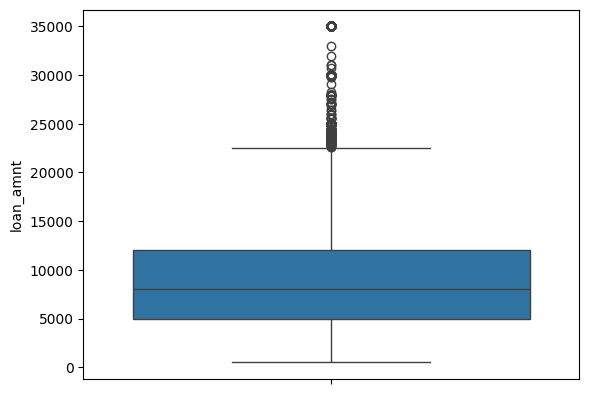

In [7]:
sns.boxplot(df_train['loan_amnt'])

In [8]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

In [9]:
for i in df_test.columns:
    if df_test[i].dtype == object :
        df_train[i] = label.fit_transform(df_train[i])
        df_test[i] = label.transform(df_test[i])

# LogisticRegression + StandardScaler + Pipeline 

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [11]:
scaler = StandardScaler()
model = LogisticRegression()

In [12]:
params = {
    'model__penalty':['l2', 'l1', 'elasticnet', None],
    'model__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'model__max_iter':[100, 500, 1000],
    'model__l1_ratio' : [0.15, 0.5, 0.85]
}

In [13]:
pipe = Pipeline([('scaler', scaler), ('model', model)])

In [14]:
final_model = GridSearchCV(pipe, param_grid=params, cv=3, scoring='accuracy', n_jobs=-1)

In [15]:
X_train = df_train.drop(['loan_status'], axis = 1)
X_test = df_test.copy()
y_train = df_train["loan_status"]

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [17]:
final_model.fit(X_train, y_train)

,estimator,Pipeline(step...egression())])
,param_grid,"{'model__l1_ratio': [0.15, 0.5, ...], 'model__max_iter': [100, 500, ...], 'model__penalty': ['l2', 'l1', ...], 'model__solver': ['lbfgs', 'liblinear', ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [18]:
final_model.best_params_

{'model__l1_ratio': 0.15,
 'model__max_iter': 100,
 'model__penalty': 'l2',
 'model__solver': 'lbfgs'}

In [19]:
final_model.best_score_

np.float64(0.8953874328218235)

In [20]:
y_pred = final_model.predict(X_val)

In [21]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10087
           1       0.75      0.43      0.55      1642

    accuracy                           0.90     11729
   macro avg       0.83      0.70      0.74     11729
weighted avg       0.89      0.90      0.89     11729



In [22]:
df_sub = pd.read_csv('sample_submission.csv')

In [23]:
finaly_y = final_model.predict_proba(X_test)

In [24]:
df_sub['loan_status'] = finaly_y[::,1]

In [25]:
df_sub.to_csv('sub.csv', index=False, index_label=False)

# xgboost

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

In [11]:
X_train = df_train.drop(['loan_status'], axis = 1)
X_test = df_test.copy()
y_train = df_train["loan_status"]

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [13]:
model = XGBClassifier()

In [14]:
params = {
    'n_estimators': [50, 60, 100, 150, 200],
}

In [15]:
final_model = GridSearchCV(model, param_grid=params, cv=3)

In [16]:
final_model.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'n_estimators': [50, 60, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [17]:
y_pred = final_model.predict(X_val)

In [18]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.90      0.74      0.81      1642

    accuracy                           0.95     11729
   macro avg       0.93      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729



In [20]:
df_sub = pd.read_csv('sample_submission.csv')
finaly_y = final_model.predict_proba(X_test)
df_sub['loan_status'] = finaly_y[::,1]
df_sub.to_csv('sub1.csv', index=False, index_label=False)